In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv("PCardTransactions15-16.csv")

In [3]:
df.head()

,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total
0,Assurance,Miscellaneous Expenses,43033820 COSTA COFFEE,18/08/2015,5043.0,2
1,Children's Family Services,Miscellaneous Expenses,99 PLUS DISCOUNT MART,08/06/2015,4184.0,29.97
2,Children's Family Services,E19 - Learning Resources,99P STORES LTD,07/12/2015,6278.0,34.65
3,Children's Family Services,Equipment and Materials Purcha,99P STORES LTD,18/08/2015,5041.0,10.72
4,Children's Family Services,Subsistence,CHOPSTIX00000000000,21/05/2015,5750.0,33.7


In [4]:
df['Journal Date'] = pd.to_datetime(df['Journal Date'])

In [5]:
df = df.convert_objects(convert_numeric=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [6]:
df.dtypes

Service Area                   object
Account Description            object
Creditor                       object
Journal Date           datetime64[ns]
Journal Reference             float64
Total                         float64
dtype: object

In [7]:
df_sorted = df.sort_values(by='Journal Date',ascending=True)

In [8]:
x = df_sorted.iloc[100:200, [4]].values

In [9]:
y = df_sorted.iloc[100:200, [5]].values

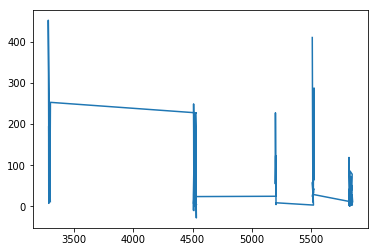

In [10]:
plt.plot(x,y)
plt.show()

In [11]:
df_clean = df_sorted.dropna(axis=0)

In [12]:
df_clean.head()

,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total
36,Children's Education & Skills,Equipment and Materials Repair,AFE SERVICELINE,2015-01-05,3037.0,479.84
1861,Children's Education & Skills,Food Costs,M & D GRODZINSKI LTD,2015-01-05,3036.0,313.65
3169,Children's Family Services,Travelling Expenses,TFL OYST PHOTOCARD,2015-01-05,3040.0,10.00
3472,Children's Service DSG,Equipment and Materials Purcha,WWW.CONNEVANS.COM,2015-01-05,3039.0,220.95
1833,Children's Family Services,Other Transfer Payments to Soc,LOVE2REWARD.CO.UK,2015-01-05,3038.0,506.00


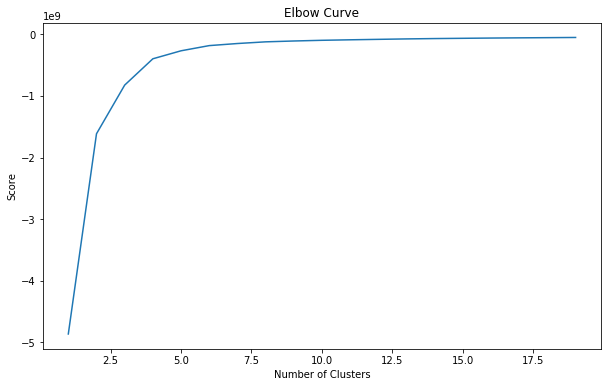

In [13]:
from sklearn.cluster import KMeans
data = df_clean[['Journal Reference', 'Total']]
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

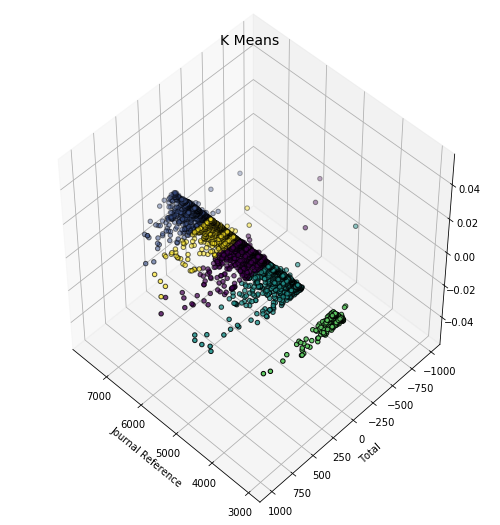

In [14]:
from mpl_toolkits.mplot3d import Axes3D
X = df_clean[['Journal Reference', 'Total']]
X = X.reset_index(drop=True)
km = KMeans(n_clusters=5)
km.fit(X)
km.predict(X)
labels = km.labels_
#Plotting
fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(X.iloc[:,0], X.iloc[:,1], c=labels.astype(np.float), edgecolor="k")
ax.set_xlabel("Journal Reference")
ax.set_ylabel("Total")
plt.title("K Means", fontsize=14);

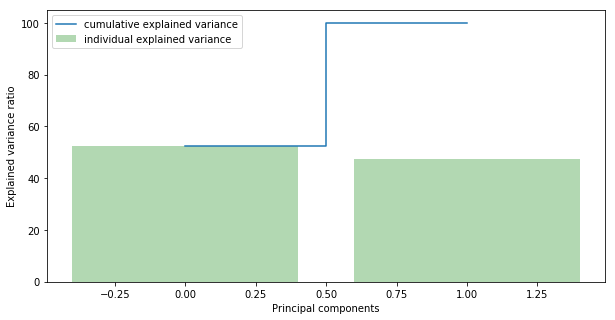

In [15]:
from sklearn.preprocessing import StandardScaler
data = df_clean[['Journal Reference', 'Total']]
X = data.values
X_std = StandardScaler().fit_transform(X)
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x: x[0], reverse= True)
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

In [16]:
data = data.reset_index(drop=True)

In [19]:
data.head()

,Journal Reference,Total
0,3037.0,479.84
1,3036.0,313.65
2,3040.0,10.00
3,3039.0,220.95
4,3038.0,506.00


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


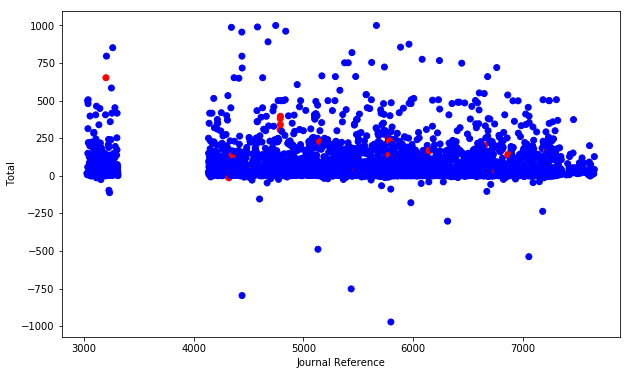

In [20]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

outliers_fraction = 0.01
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[3])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df_clean['anomaly1'] = (distance >= threshold).astype(int)
df_final = df_clean.dropna(axis=0)
# visualisation of anomaly with cluster view
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df_final['Journal Reference'], df_final['Total'], c=df_final["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('Journal Reference')
plt.ylabel('Total')
plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


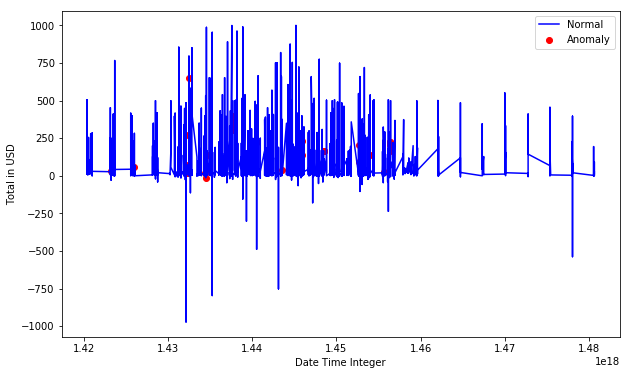

In [21]:
df_final['date_time_int'] = df_final['Journal Date'].astype(np.int64)
fig, ax = plt.subplots(figsize=(10,6))
a = df_final.loc[df_final['anomaly1'] == 1, ['date_time_int', 'Total']] #anomaly

ax.plot(df_final['date_time_int'], df_final['Total'], color='blue', label='Normal')
ax.scatter(a['date_time_int'],a['Total'], color='red', label='Anomaly')
plt.xlabel('Date Time Integer')
plt.ylabel('Total in USD')
plt.legend()
plt.show();

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


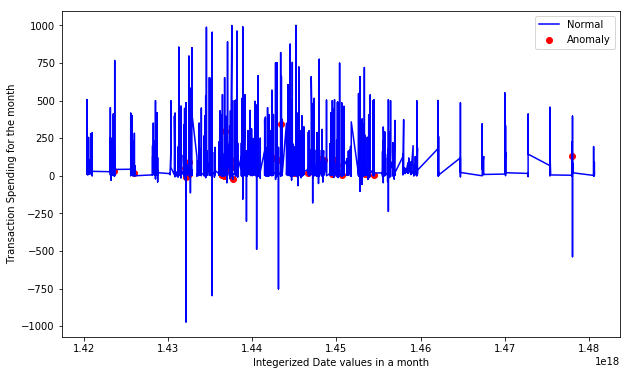

In [27]:
from sklearn import svm
data = df_final[['Journal Reference','date_time_int','Total']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train oneclassSVM 
model = svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
model.fit(data)
df_final['anomaly3'] = pd.Series(model.predict(data))

fig, ax = plt.subplots(figsize=(10,6))
a = df_final.loc[df_final['anomaly3'] == -1, ['date_time_int', 'Total']] #anomaly

ax.plot(df_final['date_time_int'], df_final['Total'], color='blue', label='Normal')
ax.scatter(a['date_time_int'],a['Total'], color='red', label='Anomaly')

plt.xlabel("Integerized Date values in a month")
plt.ylabel("Transaction Spending for the month")
plt.legend()
plt.show();